# Classifying Emotions

## Learn facial expressions from an image
The task is categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image.

## Additional Information
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image.

The training set consists of 28,709 examples and the test set consists of 3,589 examples.

## Dependency version
`Tensorflow-gpu: 2.6.0`

## Codes

**1:** Setup:

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, Add
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
# Check GPU support
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# helper functions
# Author: Xiaotian Li
def count_files(root_path):
    print('count files in:' + root_path)
    assert os.path.exists(root_path)
    total_files = 0
    item_list = os.listdir(root_path)
    if len(item_list) == 0:
        return 0
    for item in item_list:
        next_path = os.path.join(root_path, item)
        if os.path.isfile(next_path):
            total_files += 1
        else:
            total_files += count_files(next_path)

    return total_files


# retrieved from: https://edstem.org/us/courses/30707/lessons/48014/slides/273564/solution
def plot_history(history, name):
    with plt.xkcd(scale=0.2):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        for i, metric in enumerate(['loss', 'accuracy']):
            ax[i].plot(history.history[metric], label='Train', color='#EFAEA4', linewidth=3)
            ax[i].plot(history.history[f'val_{metric}'], label='Validation', color='#B2D7D0', linewidth=3)
            if metric == 'accuracy':
                ax[i].axhline(0.5, color='#8d021f', ls='--', label='Trivial accuracy')
                ax[i].set_ylabel("Accuracy", fontsize=14)
            elif metric == 'auc':
                ax[i].set_ylabel("AUC", fontsize=14)
            else:
                ax[i].set_ylabel("Loss", fontsize=14)
            ax[i].set_xlabel('Epoch', fontsize=14)

        plt.suptitle(f'{name} Training', y=1.05, fontsize=16)
        plt.legend(loc='best')
        plt.tight_layout()

def plot_confusion_matrix(confusion_matrix,cifar10_dictionary,ax=None):
    df_cm = pd.DataFrame(confusion_matrix, index = cifar10_dictionary.values(),
                         columns = cifar10_dictionary.values())
    sns.set(font_scale=1.2) # for label size
    ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap='YlOrBr')
    ax.xaxis.set_ticks_position('top')

**2:** Handle inputs

In [4]:
# Author Xiaotian Li

# Some important directories
DATA_DIR = os.path.join(".", "data")

TEST_DATA_DIR = os.path.join(DATA_DIR, "test")
TRAIN_DATA_DIR = os.path.join(DATA_DIR, "train")

BATCH_SIZE = 128
VALIDATION_RATE = 0.2
IMAGE_SIZE = 48

# count train data number
NUM_TRAIN_DATA = count_files(TRAIN_DATA_DIR)

# load the dataset
# Generate batches of tensor image data with real-time data augmentation
# rescale to convert the pixels in range [0,255] to range [0,1]. This process is Normalizing.
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=VALIDATION_RATE
)

# Validation data
dategen_valid = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=VALIDATION_RATE
)

# rescale to convert the pixels in range [0,255] to range [0,1]. This process is Normalizing.
datagen_test = ImageDataGenerator(
    rescale=1. / 255,
)

count files in:.\data\train
count files in:.\data\train\angry
count files in:.\data\train\disgust
count files in:.\data\train\fear
count files in:.\data\train\happy
count files in:.\data\train\neutral
count files in:.\data\train\sad
count files in:.\data\train\surprise


In [5]:
# Author: Xiaotian Li
# using one-hot to encode the label

# grayscale 1 channel inputs
train_img_generator = datagen.flow_from_directory(
    directory=TRAIN_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

validation_img_generator = dategen_valid.flow_from_directory(
    directory=TRAIN_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

test_img_generator = datagen_test.flow_from_directory(
    directory=TEST_DATA_DIR,
    color_mode='grayscale',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# RGB 3 channel inputs
train_rgb_img_generator = datagen.flow_from_directory(
    directory=TRAIN_DATA_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

validation_rgb_img_generator = dategen_valid.flow_from_directory(
    directory=TRAIN_DATA_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

test_rgb_img_generator = datagen_test.flow_from_directory(
    directory=TEST_DATA_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# get the number of classes,
class_indices = train_img_generator.class_indices
num_classes = len(class_indices)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


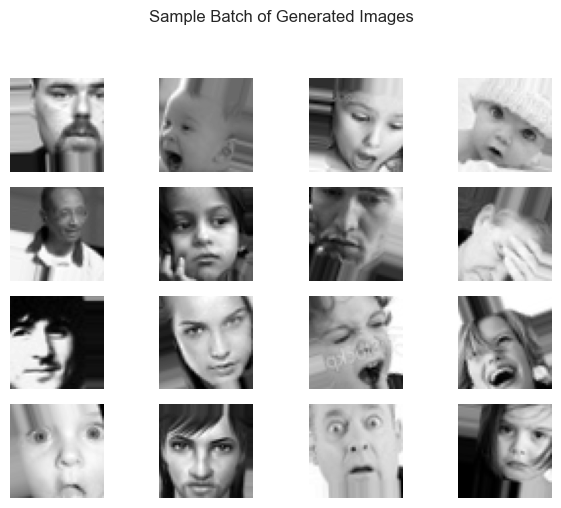

In [6]:
# Author: Xiaotian Li
# see sample generated images
# train_img_generator.next()[0] is image array
# train_img_generator.next()[1] is one-hot encoded label array
sample_batch = train_img_generator.next()[0]
fig, ax = plt.subplots(4, 4)
ax = ax.ravel()
for i, img in enumerate(sample_batch):
    if i >= 16: break
    ax[i].set_axis_off()
    ax[i].imshow(img, cmap='gray')
plt.suptitle('Sample Batch of Generated Images', y=1.05)
plt.tight_layout()

**2.** Model

In [7]:


# Author: Xiaotian Li
# model
# can only use 1-channel images
def build_demo_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu'))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same' ,activation='relu'))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same' ,activation='relu'))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(256 ,activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(512 ,activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(num_classes, activation='softmax'))

    model.summary()

    return model

### Implement with ResNet-50 Model ###
# can only use 3-channel images
def build_resnet50_model():
    base_resnet50_model = ResNet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet")

    # freeze some base layer to fine tune the resnet50
    # https://stackoverflow.com/questions/47206714/which-layers-should-i-freeze-for-fine-tuning-a-resnet-model-on-keras
    # for layer in base_resnet50_model.layers[-4:]:
    #     layer.trainable=False

    model=Sequential()
    model.add(base_resnet50_model)
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(512,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(64,kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes,activation='softmax'))

    model.summary()

    return model

### Implement with VGG16 Model ###
# https://github.com/gayathri1462/Face-Emotion-Recognition
# can only use 1-channel images
def build_VGG16_model():
    model=Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(4096))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4096))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes,activation='softmax'))

    model.summary()

    return model

# the_model = build_demo_model()
# the_model = build_VGG16_model()
the_model = build_resnet50_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                262176    
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1

**3.** Train

Epoch 1/150
179/179 [==============================] - 30s 115ms/step - loss: 1.8783 - accuracy: 0.2384 - auc: 0.6278 - val_loss: 1.8125 - val_accuracy: 0.2514 - val_auc: 0.6519
Epoch 2/150
179/179 [==============================] - 19s 103ms/step - loss: 1.8171 - accuracy: 0.2489 - auc: 0.6449 - val_loss: 1.8143 - val_accuracy: 0.2505 - val_auc: 0.6488
Epoch 3/150
179/179 [==============================] - 18s 103ms/step - loss: 1.7998 - accuracy: 0.2497 - auc: 0.6592 - val_loss: 2.1487 - val_accuracy: 0.1976 - val_auc: 0.6048
Epoch 4/150
179/179 [==============================] - 19s 104ms/step - loss: 1.7923 - accuracy: 0.2540 - auc: 0.6637 - val_loss: 2.6965 - val_accuracy: 0.2750 - val_auc: 0.6679
Epoch 5/150
179/179 [==============================] - 18s 102ms/step - loss: 1.7884 - accuracy: 0.2534 - auc: 0.6666 - val_loss: 2.0463 - val_accuracy: 0.2649 - val_auc: 0.6625
Epoch 6/150
179/179 [==============================] - 20s 110ms/step - loss: 1.7699 - accuracy: 0.2693 - auc:

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam


Epoch 00105: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

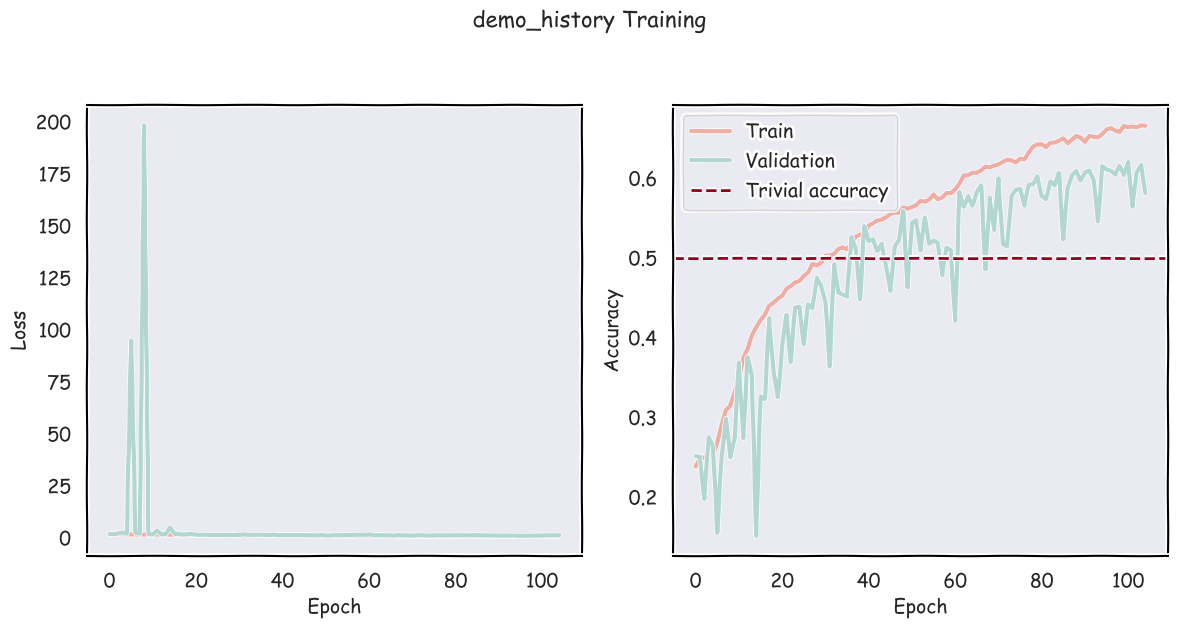

In [8]:
# Author: Xiaotian Li
optimiser = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.99)
# optimiser = SGD(learning_rate=0.005, momentum=0.9, nesterov=True)

# train
the_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimiser,
    metrics=['accuracy',  tf.keras.metrics.AUC(name='auc')]
)

# Early stopping callback
early_stop_callback = EarlyStopping(monitor='val_loss', patience = 20, mode = 'min', restore_best_weights=True)

# Reduce learning rate when metric has stopped improving.
lrd_callback = ReduceLROnPlateau(verbose = 1, factor = 0.50, min_lr = 1e-10)

# Run training
CNN_history = the_model.fit(
    train_rgb_img_generator,
    steps_per_epoch=NUM_TRAIN_DATA * (1 - VALIDATION_RATE) // BATCH_SIZE,
    epochs=150,
    verbose = 1,
    callbacks=[early_stop_callback, lrd_callback],
    validation_data=validation_rgb_img_generator,
    validation_steps=NUM_TRAIN_DATA * VALIDATION_RATE // BATCH_SIZE
)

plot_history(CNN_history, 'demo_history')

**4.** Evaluation

In [9]:
# Author: Xiaotian Li
loss, acc, auc = the_model.evaluate(test_img_generator)
print(f'Accuracy: {acc}')

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  input depth must be evenly divisible by filter depth: 1 vs 3
	 [[node sequential/resnet50/conv1_conv/Conv2D (defined at \AppData\Local\Temp\ipykernel_31576\2651137020.py:19) ]]
	 [[assert_less_equal/Assert/AssertGuard/pivot_f/_13/_37]]
  (1) Invalid argument:  input depth must be evenly divisible by filter depth: 1 vs 3
	 [[node sequential/resnet50/conv1_conv/Conv2D (defined at \AppData\Local\Temp\ipykernel_31576\2651137020.py:19) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_16497]

Function call stack:
test_function -> test_function


**5.** Confusion Matrix

In [ ]:
# TODO